# Mental Health Sentiment Analysis
### Capstone Project for Flatiron School Data Science Program
### By Matthew Gulbin

For this project, I decided to research social media sentiment analysis, particularly through the lens of mental health. To that end, I trained machine learning models to try to predict mental health conditions (anxiety, depression, etc.) based on text input from a user. 

This project is made up primarily by two files: this notebook, where I performed the data cleaning, modeling, and tuning, and a Python file for a web app that I built using Streamlit that allows the user to enter text and receive a prediction from the model.

## Data Cleaning/Prep

First, let's import our neccessary packages

In [3]:
import pandas as pd
import nltk
import torch
from datasets import Dataset
from transformers import BertTokenizer
import numpy as np
from sklearn.model_selection import train_test_split

/opt/anaconda3/envs/mental_health_proj/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Read the data to a dataframe from the file

In [2]:
df = pd.read_csv("./data/Combined Data.csv", index_col=0)

In [3]:
df

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [4]:
df['status'].value_counts(normalize=True)

status
Normal                  0.308259
Depression              0.290406
Suicidal                0.200837
Anxiety                 0.073299
Bipolar                 0.054239
Stress                  0.050318
Personality disorder    0.022642
Name: proportion, dtype: float64

Now we'll do data cleaning. First we'll drop all of the nulls

In [4]:
df = df.dropna()

Now let's save all of the possible statuses to a list, and create dictionaries mapping them to ids and back

In [5]:
labels = df['status'].unique().tolist()
labels

['Anxiety',
 'Normal',
 'Depression',
 'Suicidal',
 'Stress',
 'Bipolar',
 'Personality disorder']

In [6]:
label_to_id = {label: i for i, label in enumerate(labels)}
id_to_label = {i: label for i, label in enumerate(labels)}

label_to_id['Suicidal']
id_to_label[3]

'Suicidal'

In [7]:
df['status'] = df['status'].apply(lambda x : label_to_id[str(x)])

/var/folders/4s/pf1zdv_x4_qcflpq4m943q0m0000gn/T/ipykernel_61897/1510116700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['status'] = df['status'].apply(lambda x : label_to_id[str(x)])


Let's format the dataframe so that it's compatable with huggingface

In [9]:
df = df.rename(columns={'statement' : 'text', 'status' : 'labels'})
df

,text,labels
3008,I'm lazy to complain about it ba ihh,1
44705,i think the wifi on my iphone is broken it wil...,1
50186,Good tracking apps? I've been trying to find a...,5
13755,I have recently looked into reddit and found t...,2
32298,that's your favorite thing to do?,1
...,...,...
4069,"how come you haven't had a day off, even thoug...",1
3517,it is observed that on the 3rd of Eid my mothe...,1
21541,Id rather have ups and downs than this shit. I...,2
22802,So today marks the day I went from being twent...,2


For the purpose of training, we will take a random sample of 5000 entries

In [ ]:
df = df.sample(5000, random_state=42)
df

Train test split

In [10]:
train_df, val_df = train_test_split(df, test_size=.2, random_state=42)

## Traditional Model (Multinominal NB)

For the purpose of comparison, let's make a traditional ML model, in this case a multinominal Naive Bayes.

In [175]:
X_train = train_df['text']
X_test = val_df['text']
y_train = train_df['labels']
y_test = val_df['labels']

In [176]:
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [178]:
X_train = X_train.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

In [180]:
text_clf = Pipeline([
    ('vect', CountVectorizer(stop_words='english', ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

In [181]:
text_clf.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(ngram_range=(1, 2), stop_words='english')),
                ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

In [185]:
y_pred = text_clf.predict(X_test)
f1_score_mnb = f1_score(y_test, y_pred, average='macro')
report = classification_report(y_test, y_pred)

/opt/anaconda3/envs/mental_health_proj/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/mental_health_proj/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/mental_health_proj/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

In [186]:
print(f"Model F1: {f1_score_mnb:.2f}")
print("\nClassification Report:")
print(report)

Model Accuracy: 0.16

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        66
           1       0.94      0.42      0.58       318
           2       0.34      0.98      0.51       296
           3       0.86      0.03      0.06       207
           4       0.00      0.00      0.00        51
           5       0.00      0.00      0.00        44
           6       0.00      0.00      0.00        18

    accuracy                           0.43      1000
   macro avg       0.31      0.20      0.16      1000
weighted avg       0.58      0.43      0.34      1000



As we can see, the tradional model results in an F1 score of 0.16. This could be due to a great amount of syntactic overlap between different mental health statuses, such as depression and suicidal. Let's take a look at the confusion matrix for this model.

In [188]:
import matplotlib.pyplot as plt
import seaborn as sns

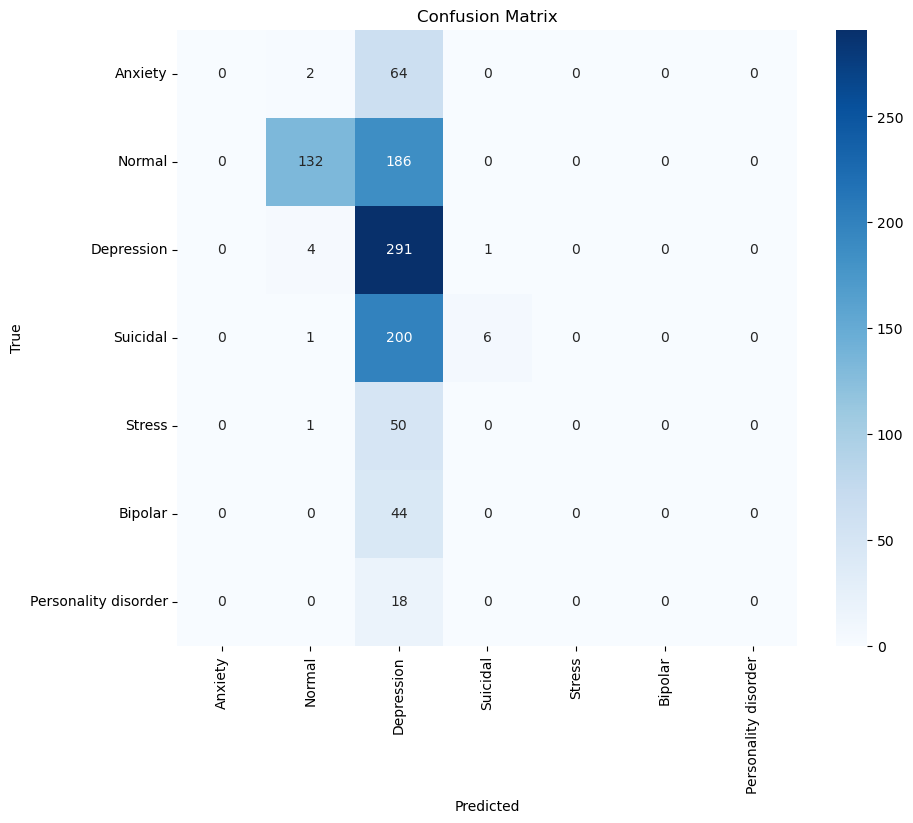

In [189]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [190]:
y_test.value_counts()

labels
1    318
2    296
3    207
0     66
4     51
5     44
6     18
Name: count, dtype: int64

## Transformer Neural Network (BERT)

Now, let's use a transformer neural network to tokenize and model our dataset. For this, we will use HuggingFace's different python libraries.

First, we have to transfer our dataframes into a Dataset, HuggingFace's data structure

In [11]:
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [13]:
def tokenize_function(examples):
    #return tokenizer(examples["text"], padding="max_length", truncation=True)
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

In [14]:
tokenized_train = train_ds.map(tokenize_function, batched=True)
tokenized_val = val_ds.map(tokenize_function, batched=True)

Map: 100%|██████████| 2000/2000 [00:02<00:00, 856.39 examples/s]


In [15]:
len(tokenized_train['input_ids'][0])

128

In [16]:
from transformers import BertForSequenceClassification, TrainingArguments, Trainer

# Initialize model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(labels)
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

/opt/anaconda3/envs/mental_health_proj/lib/python3.10/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
import numpy as np
import evaluate

metric = evaluate.load("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="macro")

In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
)

In [20]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.934200,0.607324,0.602688
2,0.497900,0.551728,0.737671
3,0.333600,0.589579,0.751955
4,0.214300,0.648793,0.762547
5,0.131100,0.733130,0.756141


TrainOutput(global_step=2500, training_loss=0.42221019287109374, metrics={'train_runtime': 4739.9814, 'train_samples_per_second': 8.439, 'train_steps_per_second': 0.527, 'total_flos': 2631228672000000.0, 'train_loss': 0.42221019287109374, 'epoch': 5.0})

In [21]:
evaluation_results = trainer.evaluate()
print(f"Evaluation results: {evaluation_results}")

Evaluation results: {'eval_loss': 0.5517283082008362, 'eval_f1': 0.7376706086526598, 'eval_runtime': 37.5823, 'eval_samples_per_second': 53.217, 'eval_steps_per_second': 3.326, 'epoch': 5.0}


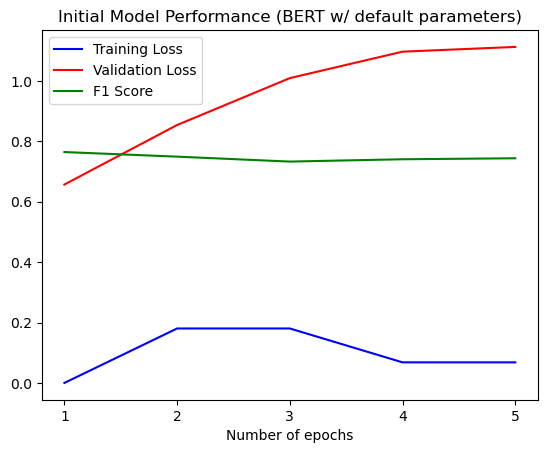

In [174]:
import matplotlib.pyplot as plt

epoch_list = [1,2,3,4,5]
train_l_list = [0,.1803,.1803,.0681,.0681]
val_l_list = [.656934, .853999, 1.009352, 1.096921, 1.112623]
f1_list = [0.764503, 0.749274, 0.732952, 0.740643, 0.743907]

plt.plot(epoch_list, train_l_list, c='b', label='Training Loss')
plt.plot(epoch_list, val_l_list, c='r', label='Validation Loss')
plt.plot(epoch_list, f1_list, c='g', label='F1 Score')

plt.title("Initial Model Performance (BERT w/ default parameters)")
plt.xlabel("Number of epochs")
plt.xticks([1,2,3,4,5])
plt.legend()
plt.show()

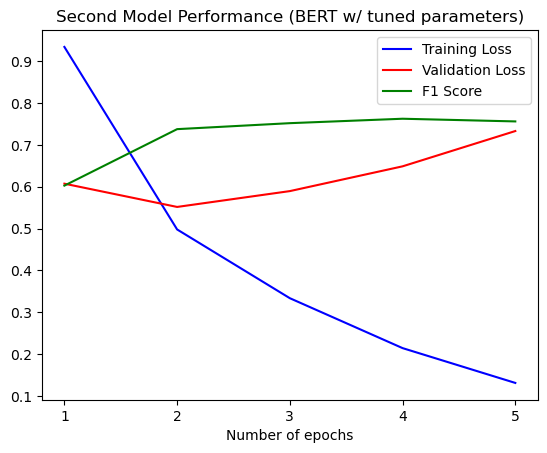

In [1]:
import matplotlib.pyplot as plt

epoch_list = [1,2,3,4,5]
train_l_list = [0.934200,0.497900,0.333600,0.214300,0.131100]
val_l_list = [0.607324, 0.551728, 0.589579, 0.648793, 0.733130]
f1_list = [0.602688, 0.737671, 0.751955, 0.762547, 0.756141]

plt.plot(epoch_list, train_l_list, c='b', label='Training Loss')
plt.plot(epoch_list, val_l_list, c='r', label='Validation Loss')
plt.plot(epoch_list, f1_list, c='g', label='F1 Score')

plt.title("Second Model Performance (BERT w/ tuned parameters)")
plt.xlabel("Number of epochs")
plt.xticks([1,2,3,4,5])
plt.legend()
plt.show()

In [22]:
model.save_pretrained('./model/bigger')
tokenizer.save_pretrained('./model/bigger')

('./model/bigger/tokenizer_config.json',
 './model/bigger/special_tokens_map.json',
 './model/bigger/vocab.txt',
 './model/bigger/added_tokens.json')

In [23]:
import json
with open("./model/bigger/label_mapping.json", "w") as f:
    json.dump({"id_to_label": id_to_label, "label_to_id": label_to_id}, f)

- implement SMOTE
- train on full dataset

## Undersampling

In [29]:
df = pd.read_csv("./data/Combined Data.csv", index_col=0)

In [30]:
df = df.dropna()

In [53]:
labels = df['status'].unique().tolist()
labels

['Anxiety',
 'Normal',
 'Depression',
 'Suicidal',
 'Stress',
 'Bipolar',
 'Personality disorder']

In [54]:
label_to_id = {label: i for i, label in enumerate(labels)}
id_to_label = {i: label for i, label in enumerate(labels)}

label_to_id['Suicidal']
id_to_label[3]

'Suicidal'

In [33]:
df['status'] = df['status'].apply(lambda x : label_to_id[str(x)])

In [57]:
df = df.rename(columns={'statement' : 'text', 'status' : 'labels'})
df

,text,labels
0,oh my gosh,0
1,"trouble sleeping, confused mind, restless hear...",0
2,"All wrong, back off dear, forward doubt. Stay ...",0
3,I've shifted my focus to something else but I'...,0
4,"I'm restless and restless, it's been a month n...",0
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,0
53039,"selfishness ""I don't feel very good, it's lik...",0
53040,Is there any way to sleep better? I can't slee...,0
53041,"Public speaking tips? Hi, all. I have to give ...",0


In [58]:
#df = df.sample(5000, random_state=42)
df

,text,labels
0,oh my gosh,0
1,"trouble sleeping, confused mind, restless hear...",0
2,"All wrong, back off dear, forward doubt. Stay ...",0
3,I've shifted my focus to something else but I'...,0
4,"I'm restless and restless, it's been a month n...",0
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,0
53039,"selfishness ""I don't feel very good, it's lik...",0
53040,Is there any way to sleep better? I can't slee...,0
53041,"Public speaking tips? Hi, all. I have to give ...",0


In [59]:
df['labels'].value_counts()

labels
1    16343
2    15404
3    10652
0     3841
5     2777
4     2587
6     1077
Name: count, dtype: int64

In [75]:
df[df['labels'] == 6]

,text,labels
50654,Is there anyone interested in joining a group ...,6
50656,Anyone else have nothing in common with other ...,6
50657,Being a ghost would be my ideal form of existe...,6
50659,I am hurting Lately I just feel like garbage. ...,6
50660,I can't cope with my job I work from home as a...,6
...,...,...
51849,Could you change and get better through lots o...,6
51851,How to not hurt peoples feelings I think I’m d...,6
51852,Do you have goals? I realised that I never rea...,6
51853,I feel like I’ve missed out on my teenage year...,6


In [60]:
balanced_df = df.groupby('labels', as_index=False, group_keys=False).apply(lambda s : s.sample(1077, replace=True))
balanced_df['labels'].value_counts()

/var/folders/4s/pf1zdv_x4_qcflpq4m943q0m0000gn/T/ipykernel_72876/2704669417.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('labels', as_index=False, group_keys=False).apply(lambda s : s.sample(1077, replace=True))


labels
0    1077
1    1077
2    1077
3    1077
4    1077
5    1077
6    1077
Name: count, dtype: int64

In [61]:
train_df, val_df = train_test_split(balanced_df, test_size=.2, random_state=42)

In [62]:
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)

In [63]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [64]:
def tokenize_function(examples):
    #return tokenizer(examples["text"], padding="max_length", truncation=True)
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

In [65]:
tokenized_train = train_ds.map(tokenize_function, batched=True)
tokenized_val = val_ds.map(tokenize_function, batched=True)

Map: 100%|██████████| 1508/1508 [00:02<00:00, 716.88 examples/s]


In [66]:
from transformers import BertForSequenceClassification, TrainingArguments, Trainer

# Initialize model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(labels)
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [67]:
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

/opt/anaconda3/envs/mental_health_proj/lib/python3.10/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [68]:
import numpy as np
import evaluate

metric = evaluate.load("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="macro")

In [69]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
)

In [70]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,0.694737,0.741602
2,1.035600,0.575308,0.804124
3,0.425000,0.571271,0.810868
4,0.227000,0.577744,0.818549
5,0.227000,0.610594,0.821992


TrainOutput(global_step=1885, training_loss=0.4747196490948017, metrics={'train_runtime': 3626.4986, 'train_samples_per_second': 8.315, 'train_steps_per_second': 0.52, 'total_flos': 1983617515104000.0, 'train_loss': 0.4747196490948017, 'epoch': 5.0})

In [71]:
evaluation_results = trainer.evaluate()
print(f"Evaluation results: {evaluation_results}")

Evaluation results: {'eval_loss': 0.5712706446647644, 'eval_f1': 0.8108678252015726, 'eval_runtime': 28.1462, 'eval_samples_per_second': 53.577, 'eval_steps_per_second': 3.375, 'epoch': 5.0}


In [72]:
model.save_pretrained('./model/final')
tokenizer.save_pretrained('./model/final')

('./model/final/tokenizer_config.json',
 './model/final/special_tokens_map.json',
 './model/final/vocab.txt',
 './model/final/added_tokens.json')

In [74]:
import json
with open("./model/final/label_mapping.json", "w") as f:
    json.dump({"id_to_label": id_to_label, "label_to_id": label_to_id}, f)